In [1]:
from myutil.baseGPR import GPModel, GPTrainer 
import torch
import time
import matplotlib.pyplot as plt
import numpy as np

time:  597.4117729663849


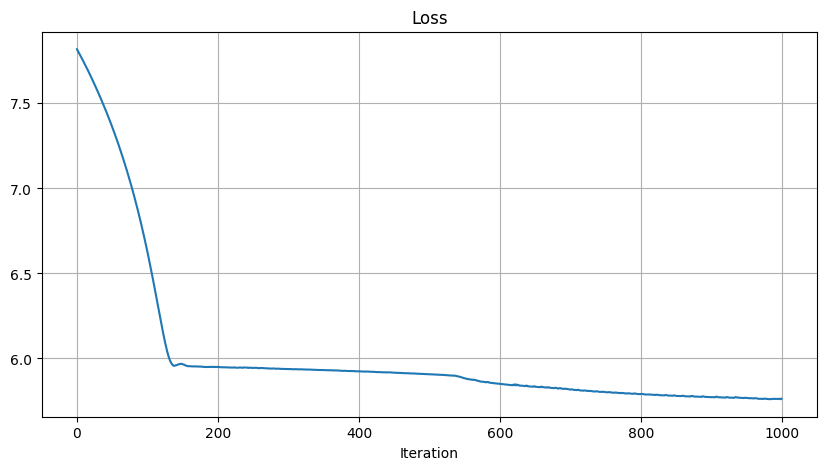

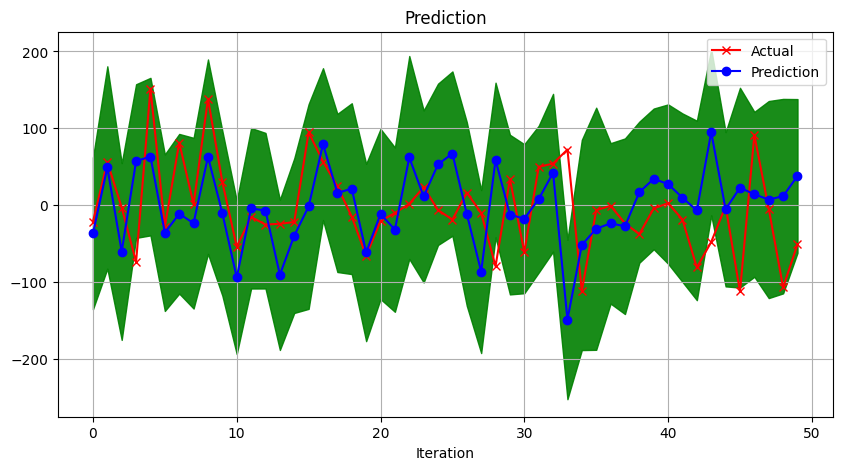

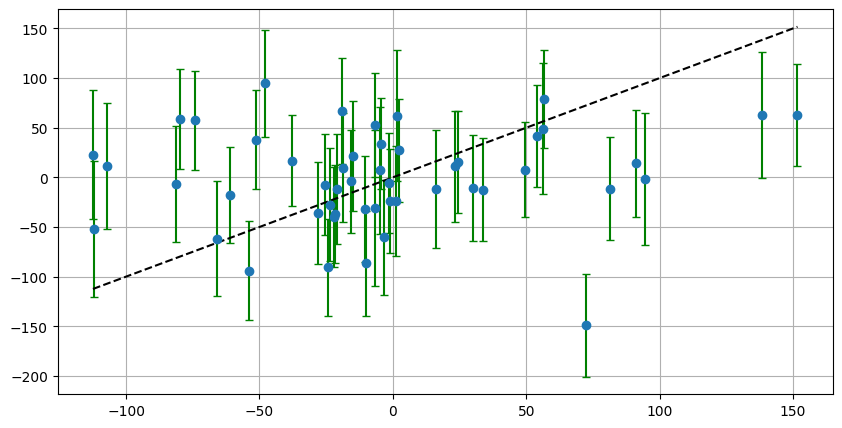

In [2]:
# ランダムなトレーニングデータを生成
n_data = 550
n_test = 50
n_iter = 1000
num_mixtures = 5
is_spectral = True
# is_spectral = False


# 実験用データを生成
data_x = torch.from_numpy(np.random.normal(3, 1, (n_data,3)))
data_x_add = torch.from_numpy(np.random.normal(0, 1, (n_data,3)))
data_y = data_x_add[0,1]+data_x[:,2]*torch.sin(data_x_add[:,0])*torch.exp(data_x[:,1]) + 0.5 * torch.from_numpy(np.random.normal(0, 1, n_data))

# トレーニングデータとテストデータに分割
train_x = data_x[:n_data - n_test]
train_y = data_y[:n_data - n_test]

test_x = data_x[n_data - n_test:]
test_y = data_y[n_data - n_test:]


# gpuが使える場合はgpuを使う
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# モデルと尤度関数を初期化
if is_spectral:
    model, likelihood, trainer = GPModel.spectral_initialize(train_x, 
                                                         train_y, 
                                                         device=device,
                                                         num_mixtures=10)
else:
    model, likelihood, trainer = GPModel.standard_initialize(train_x, 
                                                             train_y, 
                                                             device=device)

start_time = time.time()
# モデルを学習
losses = trainer.train(model, likelihood, train_x, train_y, n_iter=n_iter, lr=0.05)
print("time: ", time.time() - start_time)

# テストデータで予測
mean, variance = trainer.predict(test_x)

mean = mean.numpy().flatten()
std = np.sqrt(variance.numpy().flatten())

# 予測結果を表示
# print("Predicted mean:", mean)
# print("standard deviation:", std)

# lossの推移を表示
plt.figure(figsize=(10, 5))
plt.plot(losses)
# グラフのタイトルを表示
plt.title("Loss")
# x軸のラベルを表示
plt.xlabel("Iteration")
plt.grid()
plt.show()

# 実績値と予測値の誤差範囲を表示
plt.figure(figsize=(10, 5))
plt.fill_between(range(n_test), 
                 mean - 2 * std, 
                 mean + 2 * std, 
                 alpha=0.9, color='g')

# 実績値を表示
plt.plot(range(n_test), test_y.numpy().flatten(), 'r', marker='x',label="Actual")
# 予測値を表示
plt.plot(range(n_test), mean, 'b', marker='o',label="Prediction")   
plt.legend()
# グラフのタイトルを表示
plt.title("Prediction")
# x軸のラベルを表示
plt.xlabel("Iteration")
plt.grid()
plt.show()

# 実績値と予測値の45度線を表示
vmin = np.min(test_y.numpy().flatten())
vmax = np.max(test_y.numpy().flatten())
plt.figure(figsize=(10, 5))
plt.errorbar(test_y.numpy().flatten(), mean, yerr=std, fmt='o', ecolor='g', capthick=1, capsize=3, label="Prediction")
plt.plot([vmin, vmax], [vmin, vmax], 'k--', label="45 degree line")
plt.grid()
plt.show()

In [15]:
print(test_y.shape)

torch.Size([50, 150])


In [7]:
data_x = torch.from_numpy(np.random.normal(0, 1, (n_data,2)))
print(data_x.shape)

torch.Size([100, 2])


In [ ]:
# gpytorch を使ったガウス過程回帰の使い方の確認
# 必要なライブラリのインポート

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import gpytorch
import time
import scipy.stats as stats

In [ ]:
# テストデータの作成
# y = x1*sin(x2) + x2*cos(x1) + noise
# x1, x2 はそれぞれ 0 から 100 の範囲での一様分布で1000 点
# noise は平均 0, 標準偏差 5 の正規分布で生成
# csv ファイルとして保存
# indexとしては 0 から 999 までの整数を用いる
# 乱数列は毎回同じものを生成するために seed を固定する。

np.random.seed(0)

n = 1000
x1 = np.random.uniform(0, 100, n)
x2 = np.random.uniform(0, 200, n)
noise = np.random.normal(0, 5, n)
y = np.sin(x2) + np.cos(x1) + noise

df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
df.index = np.arange(0, n)
df.index.name = 'index'
df.to_csv('test_data.csv', index=True)

In [ ]:
# データの読み込み (csv ファイルから)
# index は自動で読み込まれるので注意

df = pd.read_csv('test_data.csv', index_col='index')

# indexがｎ以下のデータを学習データ、それ以降をテストデータとする
# 今回は n = 800 とする
# dfのうちyが目的変数、x1,x2が説明変数となる

n = 800
train_df = df.iloc[:n]
test_df = df.iloc[n:]

# 説明変数と目的変数を tensor 配列に変換
# 今回は説明変数は2次元となる

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {} device'.format(device))

x_train = torch.tensor(train_df[['x1', 'x2']].values, dtype=torch.float)
y_train = torch.tensor(train_df['y'].values, dtype=torch.float)
# Move data to the appropriate device
x_train = x_train.to(device)
y_train = y_train.to(device)

x_test = torch.tensor(test_df[['x1', 'x2']].values, dtype=torch.float)
y_test = torch.tensor(test_df['y'].values, dtype=torch.float)

In [ ]:
# ガウス過程回帰モデルの定義
# 今回はガウス過程回帰モデルの定義に gpytorch を用いる
# 観測誤差も考慮するためにlikelihoodを定義する

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1]))

    def set_mean_module(self, mean_module):
        self.mean_module = mean_module  

    def set_covar_module(self, covar_module):
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.to(device)

model = GPRegressionModel(x_train, y_train, likelihood)
model.to(device)

mk = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(ard_num_dims=x_train.shape[1]))
model.set_covar_module(mk)

# 学習
# 今回は最適化手法としてAdamを用いる
model.train()
likelihood.train()


optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


training_iter = 500
start_time = time.time()
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    # print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

print('Learning time: %.3f' % (time.time() - start_time))


In [ ]:
# テストデータに対する予測

preds = []
probs = []
stds = []
acts = []

model.eval()
likelihood.eval()
for iloop in range(len(x_test)):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(x_test[iloop].reshape(1, 2)))

    # observed_predから平均と分散を取得
    mean = observed_pred.mean
    variance = observed_pred.variance
    std_dev = torch.sqrt(variance)

    # scipyの正規分布オブジェクトを作成
    norm_dist = stats.norm(loc=mean.detach().numpy(), scale=std_dev.detach().numpy())

    # x以下となる確率を計算
    probability_less_than_x = norm_dist.cdf(0)

    # 結果の表示
    # print('mean: %.3f' % mean)
    # print('std_dev: %.3f' % std_dev)
    # print('probability_less_than_x: %.3f' % probability_less_than_x)

    preds.append(mean.item())
    probs.append(1-probability_less_than_x.item())
    stds.append(std_dev.item())
    acts.append(y_test[iloop].item())

tmp_df = pd.DataFrame({'Actual': acts, 'Pred': preds, 'Prob': probs, 'Std': stds})

print(tmp_df)

In [ ]:
print(len(x_test))

In [ ]:

# probability_less_than_x のヒストグラムを作成

plt.hist(probability_less_than_x, bins=20)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Histogram of probability')
plt.show()

# 予測と予測誤差と実測値のプロット

plt.plot(range(200), mean, 'r', label='prediction')
plt.scatter(range(200), y_test, label='actual', s=2)
plt.fill_between(range(200), mean - 3.0*std_dev, mean + 3.0*std_dev, alpha=0.5)
plt.legend(loc='upper left')
plt.xlabel('index')
plt.ylabel('y')
plt.title('Prediction and actual')
plt.grid(True)
plt.show()


In [ ]:
print(x_train[-3:])
print(x_test[0])
v = torch.cat((x_train, x_test[0].reshape(1,2)), dim=0)
print(v[-3:])

# vの大きさを確認
print(v.shape)

# x_testの最初の行を削除
x